# Uncertainties in Greenland mass loss due to uncertainties in accounting

### Group Project International Summer School in Glaciology, McCarthy, June 7-17 2024

## **How much mass is the Greenland Ice Sheet losing?**

Published numbers vary not only due to the use of different data sets and methods, but also due to use of different ice sheet and basin outlines. Sometimes, glaciers and ice caps disconnected from the main ice sheet are included, sometimes they are not. This makes comparison challenging, and a community consensus is needed. In this project, we will explore different methods for basin delineation.

<img src="gris_basins_tweet.png" alt="Tweet by Hester Jiskoot on the plethora of Greenland basins" style="width: 500px;"/>

## Method 1: Delineation using flowlines

In [330]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gp
import shapely
from shapely.geometry import Point, LineString, shape, Polygon
import pylab as plt

from glacier_flow_tools.interpolation import velocity
from glacier_flow_tools.pathlines import (
    compute_pathline,
    series_to_pathline_geopandas_dataframe,
    pathline_to_line_geopandas_dataframe,
)
from glacier_flow_tools.utils import register_colormaps
register_colormaps()

ValueError: A colormap named "speed" is already registered.

In [2]:
CW = gp.read_file('data/kuba-devide/CW.shp')
SW = gp.read_file('data/kuba-devide/SW_boundary.shp')
NW = gp.read_file('data/kuba-devide/NW_Boundary.shp')

Start points for testing:
Point(-208_950, -2_294_747), Point(-210_477, -2_294_869), Point(-212_792, -2_299_682), Point(-216_082, -2_300_840) <- dont work for now
Point(-201_960, -2_200_568), Point(-200_223, -2_202_620)
Point(-198_960, -2_200_989), Point(-200_549, -2_199_410)
Point(-188_000, -2_255_000), Point(-182_000, -2_290_000) <- Jakobshavn
x -2_180_000, -2_175_000
y -2_180_000, -2_175_000
Point(-201_226, -2_249_818), Point(-208_295, -2_250_154)

Glaciers for testing

Sermeq Kujalleq (Store Glacier): Point(-207_866, -2_130_574), Point(-204_720, -2_134_735)
Sermeq Kujalleq (Store Glacier) (inland): Point(-206_410, -2_131_166), Point(-204_720, -2_134_735)
Sermeq Avannarleq: Point(-203_029, -2_170_415), Point(-198_585, -2_170_854)
Sermeq Kujalleq: Point(-195_787, -2_178_044), Point(-195_955, -2_182_912)
Kangilernata Sermia: Point(-204_906, -2_187_504), Point(-202_368, -2_189362)
Eqip Sermia: Point(-200_634, -2_199_949), Point(-199_582, -2_201_002)
Sermeq Avannarleq: Point(-209_541, -2_249_128), Point(-208_250, -2_249_698)
Jakobshavn Isbrae (Sermeq Kujalleq) (front): Point(-190_451, -2_268_829), Point(-185_980, -2_276_618)
Jakobshavn Isbrae (Sermeq Kujalleq) (Andy): Point(-188_000, -2_255_000), Point(-182_000, -2_290_000)
Alanngorliup Sermia: Point(-207_707, -2_297_501), Point(-210_029, -2_298_538)
Saqqarliup Sermia: Point(-212_792, -2_299_682), Point(-216_082, -2_300_840)

In [400]:
hmin = 0.05
hmax = 5
tol = 0.5
start_time = 0
end_time = 5_000
v_threshold = 10
starting_points = [ 
                    Point(-207_866, -2_130_574), Point(-204_720, -2_134_735),
                    Point(-202_117, -2_169_076), Point(-198_585, -2_170_854),
                    Point(-195_787, -2_178_044), Point(-195_955, -2_182_912),
                    Point(-204_906, -2_187_504), Point(-202_368, -2_189362),
                    Point(-200_634, -2_199_949), Point(-199_582, -2_201_002),
                    Point(-209_541, -2_249_128), Point(-208_250, -2_249_698),
                    Point(-188_528, -2_264_310), Point(-185_980, -2_276_618),
                    Point(-207_707, -2_297_501), Point(-210_029, -2_298_538),
                    Point(-212_792, -2_299_682), Point(-216_082, -2_300_840)
]

ds = xr.open_dataset("data/its_live_jak.nc")
Vx = np.squeeze(ds["vx"].to_numpy())
Vy = np.squeeze(ds["vy"].to_numpy())

# Reverse for backward pathlines
Vx = -Vx
Vy = -Vy

x = ds["x"].to_numpy()
y = ds["y"].to_numpy()

geom = starting_points
starting_points_df = gp.GeoDataFrame(geometry=geom, crs="EPSG:3413")

pathlines = []
for _, df in starting_points_df.iterrows():
    pathline = compute_pathline(
        [*df.geometry.coords[0]],
        velocity,
        f_args=(Vx, Vy, x, y),
        hmin=hmin,
        hmax=hmax,
        tol=tol,
        start_time=start_time,
        end_time=end_time,
        notebook=True,
        progress=True,
        v_threshold = v_threshold
    )
    pathlines.append(pathline)


Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

/opt/anaconda3/envs/glacier-flow-tools/lib/python3.11/site-packages/glacier_flow_tools/pathlines.py:246: RuntimeWarning: divide by zero encountered in scalar divide
  s = (tol / r) ** 0.25


Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

In [401]:
# Combine the pathlines into a GeoPandas DataFrame

result = pd.concat(        [
    series_to_pathline_geopandas_dataframe(s.drop("geometry", errors="ignore"), pathlines[k])
    for k, s in starting_points_df.iterrows()
]
                  ).reset_index(drop=True)


In [402]:
# Combine the pathlines into a GeoPandas DataFrame

result = pd.concat(        [
    series_to_pathline_geopandas_dataframe(s.drop("geometry", errors="ignore"), pathlines[k])
    for k, s in starting_points_df.iterrows()
]
                  ).reset_index(drop=True)


In [403]:
result

,geometry,vx,vy,v,pathline_id,distance,distance_from_origin,time,error
0,POINT (-207866.000 -2130574.000),213.727148,156.454490,264.872236,0,0.000000,0.000000,0.000000,0.000000e+00
1,POINT (-206732.882 -2129988.043),213.727148,156.454490,264.872236,0,1275.657728,1275.657728,5.000000,4.032711e-01
2,POINT (-206732.882 -2129988.043),213.727148,156.454490,264.872236,0,0.000000,1275.657728,5.000000,1.836825e+00
3,POINT (-206732.882 -2129988.043),213.727148,156.454490,264.872236,0,0.000000,1275.657728,5.000000,8.539856e-01
4,POINT (-205877.869 -2129680.747),213.727148,156.454490,264.872236,0,908.558202,2184.215930,8.159188,2.402117e-01
...,...,...,...,...,...,...,...,...,...
18490,POINT (84196.948 -2378124.285),16.250623,-71.006212,72.842054,17,99.878427,319374.509785,4980.000000,9.244587e-07
18491,POINT (84290.959 -2378155.945),16.250623,-71.006212,72.842054,17,99.198426,319473.708212,4985.000000,1.232718e-10
18492,POINT (84384.240 -2378187.709),16.250623,-71.006212,72.842054,17,98.540884,319572.249096,4990.000000,9.496886e-06
18493,POINT (84476.848 -2378219.539),16.250623,-71.006212,72.842054,17,97.925336,319670.174432,4995.000000,1.026163e-10


In [404]:
# Now results are lines
result = pd.concat(
        [
            pathline_to_line_geopandas_dataframe(pathlines[k][0], attrs={"pathline_id": [k]})
            for k, _ in starting_points_df.iterrows()
        ]
    ).reset_index(drop=True)
result.to_file('2lines.shp', mode="w")

/var/folders/nd/kkcv2d591j11jk2h39wv8_zr0000gr/T/ipykernel_15135/827185828.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result.to_file('2lines.shp', mode="w")


<Axes: xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

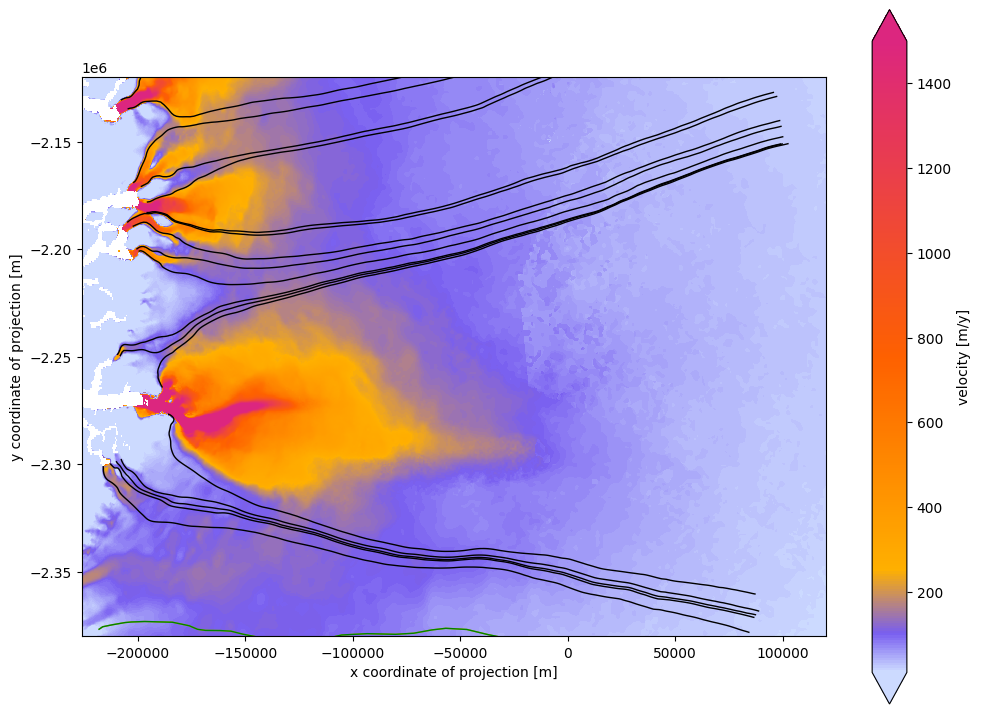

In [405]:
ratio = (y.max() - y.min()) / (x.max() - x.min())
fig, ax = plt.subplots(1, figsize=(12, 12 * ratio))
ax.set_xlim(-2_395_861, -1_846_930)
ax.set_ylim( -271_923, 308_375)
ds["v"].plot(ax=ax, cmap="speed_colorblind", vmin=10, vmax=1500)
result.plot(markersize=25,
            color="black",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
CW.plot(markersize=25,
            color="y",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
SW.plot(markersize=25,
            color="g",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
NW.plot(markersize=25,
            color="b",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)

In [386]:
#result.to_file(line_p, mode="w")

<Axes: >

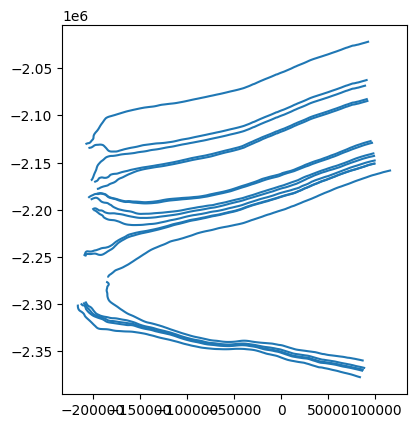

In [387]:
result.plot()

In [93]:
regions = ["NW", "NE", "NO", "SE", "SW", "CW"]
imbie_regions = {}
for r in regions:
    imbie_regions[r] = imbie[imbie["SUBREGION1"] == r].reset_index()
line = imbie_regions["CW"].intersection(imbie_regions["SE”])
line.line_merge(directed=True)

SyntaxError: unterminated string literal (detected at line 5) (1963940419.py, line 5)

In [ ]:
# Connect the terminus dots with a straight line, for now, testing the area calculation. 
term_line = LineString([Point(-188_000, -2_255_000), Point(-182_000, -2_290_000)])
term_line = pd.concat(
        [
            pathline_to_line_geopandas_dataframe([Point(-188_000, -2_255_000), Point(-182_000, -2_290_000)], attrs={"pathline_id": [k]})
            for k, _ in starting_points_df.iterrows()
        ]
    ).reset_index(drop=True)

<Axes: >

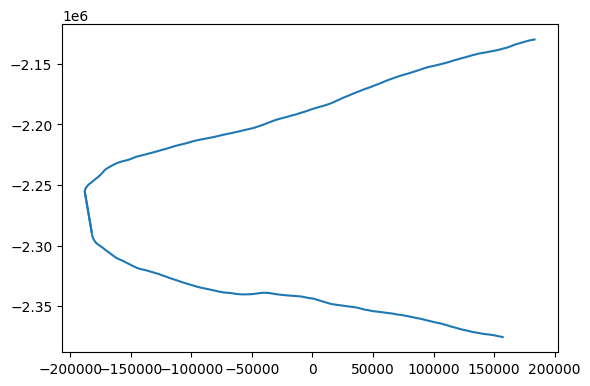

In [69]:
result_3 = pd.concat([result.geometry,term_line.geometry])
result_3.plot()

## Tasks

- Visualize different drainage basins
- Calculate pathlines and find a way to close them, making a polygon
- Explore role of uncertainties in ITS_LIVE
- Smooth DEM and use Drainage basin calculator

In [97]:
CW

,id,geometry,coords
0,1,"LINESTRING (-218242.252 -2376900.638, -218031....","[[-2376900.638018128, -218242.2520467133], [-2..."


# 1. box dots
many pathlines

In [211]:
x_coord = list(range(-200_000, -170_000, 3000))
y_coord = list(range(-2_290_000, -2_250_000, 5000))
box_points = []
for i in range(0,len(x_coord)):
    for j in range(0,len(y_coord)):
        box_points += [Point(x_coord[i],y_coord[j])]
box_points

[<POINT (-200000 -2290000)>,
 <POINT (-200000 -2285000)>,
 <POINT (-200000 -2280000)>,
 <POINT (-200000 -2275000)>,
 <POINT (-200000 -2270000)>,
 <POINT (-200000 -2265000)>,
 <POINT (-200000 -2260000)>,
 <POINT (-200000 -2255000)>,
 <POINT (-197000 -2290000)>,
 <POINT (-197000 -2285000)>,
 <POINT (-197000 -2280000)>,
 <POINT (-197000 -2275000)>,
 <POINT (-197000 -2270000)>,
 <POINT (-197000 -2265000)>,
 <POINT (-197000 -2260000)>,
 <POINT (-197000 -2255000)>,
 <POINT (-194000 -2290000)>,
 <POINT (-194000 -2285000)>,
 <POINT (-194000 -2280000)>,
 <POINT (-194000 -2275000)>,
 <POINT (-194000 -2270000)>,
 <POINT (-194000 -2265000)>,
 <POINT (-194000 -2260000)>,
 <POINT (-194000 -2255000)>,
 <POINT (-191000 -2290000)>,
 <POINT (-191000 -2285000)>,
 <POINT (-191000 -2280000)>,
 <POINT (-191000 -2275000)>,
 <POINT (-191000 -2270000)>,
 <POINT (-191000 -2265000)>,
 <POINT (-191000 -2260000)>,
 <POINT (-191000 -2255000)>,
 <POINT (-188000 -2290000)>,
 <POINT (-188000 -2285000)>,
 <POINT (-1880

In [212]:
hmin = 0.01
hmax = 25.0
tol = 1
start_time = 0
end_time = 5_000

ds = xr.open_dataset("data/its_live_jak.nc")
Vx = np.squeeze(ds["vx"].to_numpy())
Vy = np.squeeze(ds["vy"].to_numpy())

# Reverse for backward pathlines
Vx = -Vx
Vy = -Vy

x = ds["x"].to_numpy()
y = ds["y"].to_numpy()

geom = box_points
starting_points_df = gp.GeoDataFrame(geometry=geom, crs="EPSG:3413")

pathlines = []
for _, df in starting_points_df.iterrows():
    pathline = compute_pathline(
        [*df.geometry.coords[0]],
        velocity,
        f_args=(Vx, Vy, x, y),
        hmin=hmin,
        hmax=hmax,
        tol=tol,
        start_time=start_time,
        end_time=end_time,
        notebook=True,
        progress=True,
    )
    pathlines.append(pathline)

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

In [213]:
# Combine the pathlines into a GeoPandas DataFrame

result = pd.concat(        [
    series_to_pathline_geopandas_dataframe(s.drop("geometry", errors="ignore"), pathlines[k])
    for k, s in starting_points_df.iterrows()
]
                  ).reset_index(drop=True)

In [214]:
# Now results are lines
result = pd.concat(
        [
            pathline_to_line_geopandas_dataframe(pathlines[k][0], attrs={"pathline_id": [k]})
            for k, _ in starting_points_df.iterrows()
        ]
    ).reset_index(drop=True)
    #result.to_file(line_p, mode="w")



<Axes: xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

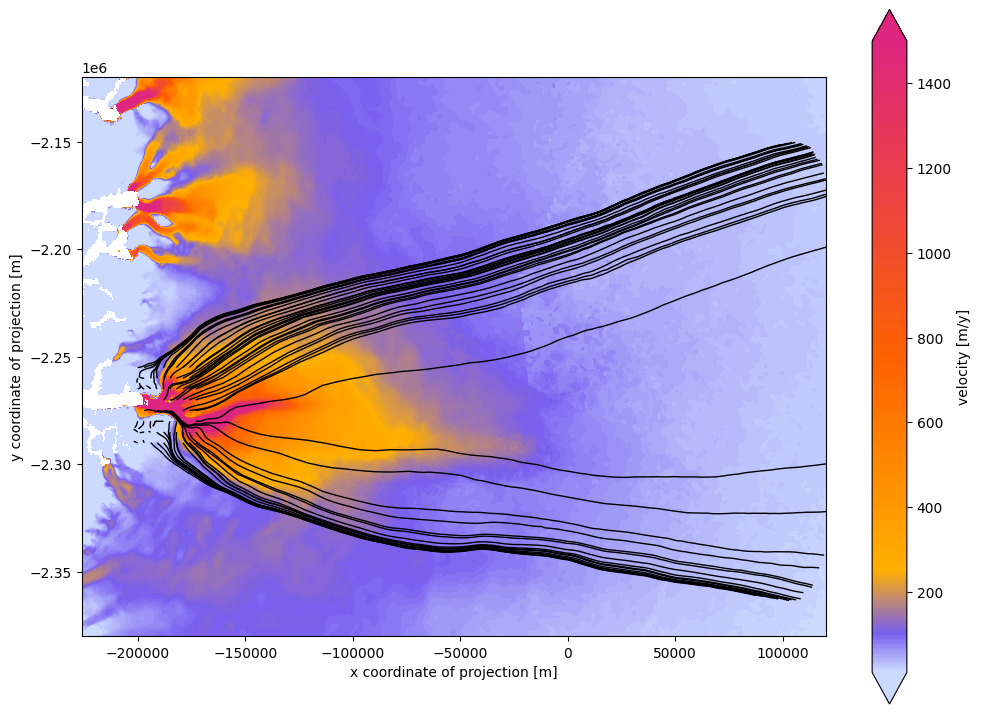

In [215]:
ratio = (y.max() - y.min()) / (x.max() - x.min())
fig, ax = plt.subplots(1, figsize=(12, 12 * ratio))
ds["v"].plot(ax=ax, cmap="speed_colorblind", vmin=10, vmax=1500)
result.plot(markersize=25,
            color="black",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)

# 2. Plotting the devide
we are starting with plotting a devide file defined by other people. 

<Axes: xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

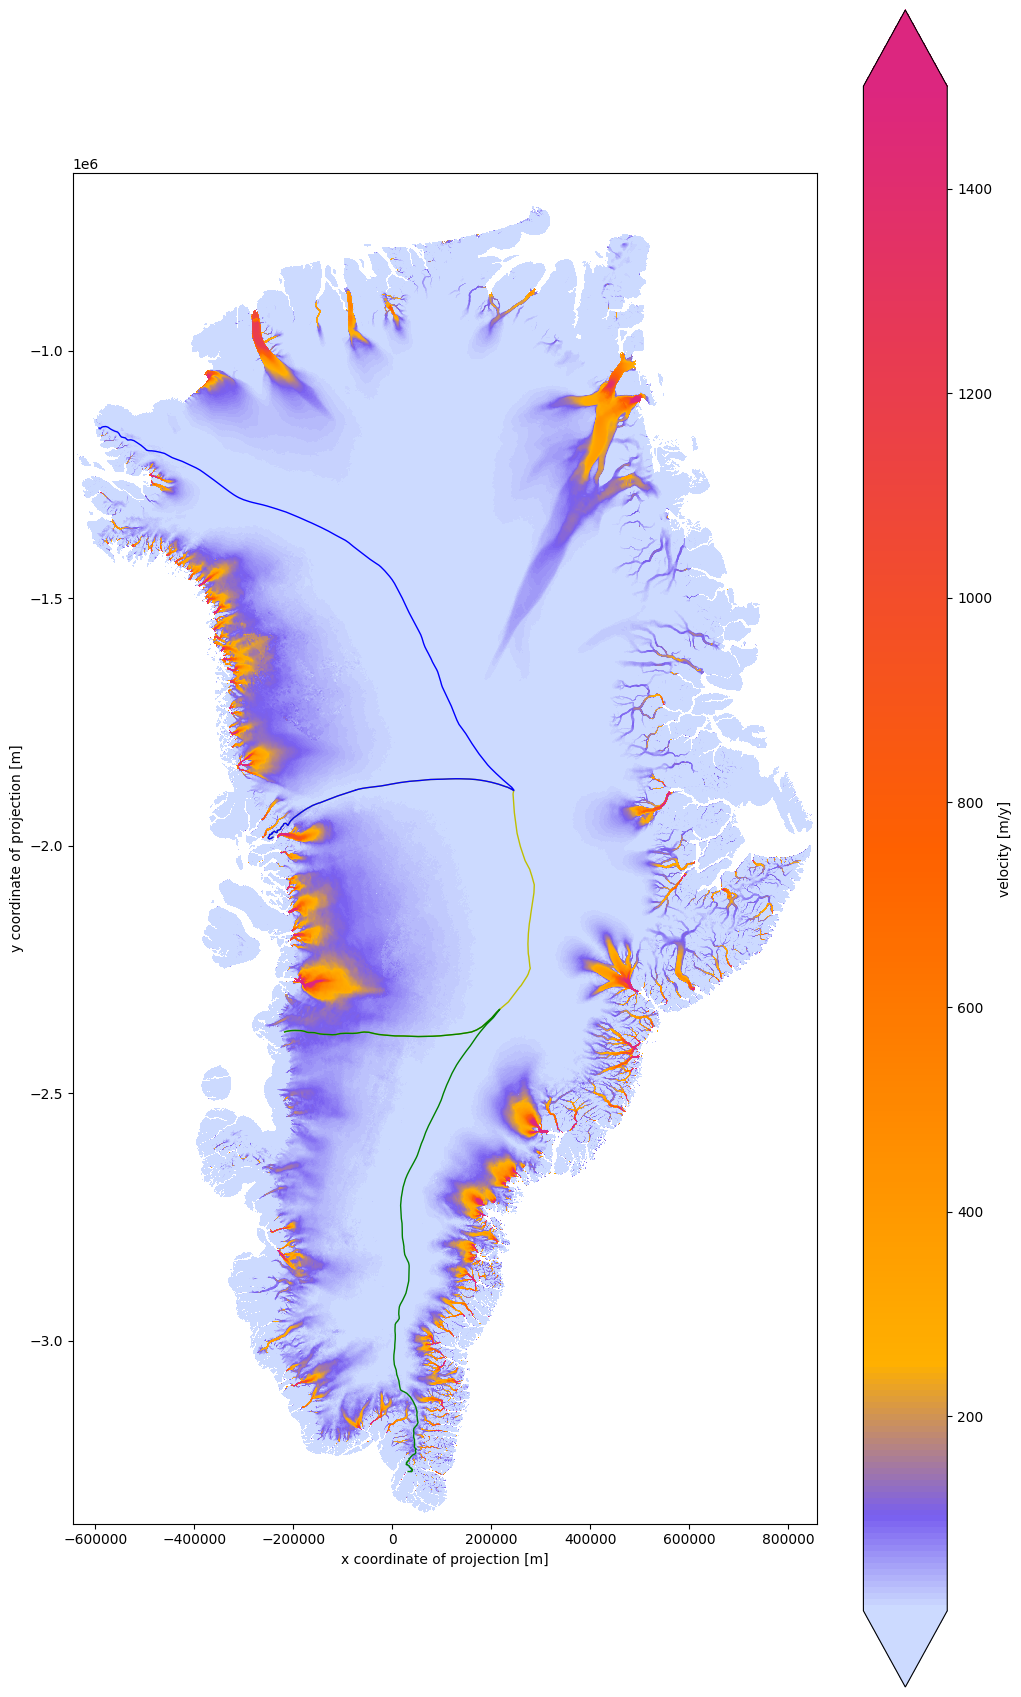

In [88]:
ratio = (y.max() - y.min()) / (x.max() - x.min())
fig, ax = plt.subplots(1, figsize=(12, 12 * ratio))
ds["v"].plot(ax=ax, cmap="speed_colorblind", vmin=10, vmax=1500)
CW.plot(markersize=25,
            color="y",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
SW.plot(markersize=25,
            color="g",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
NW.plot(markersize=25,
            color="b",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)

<Axes: xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

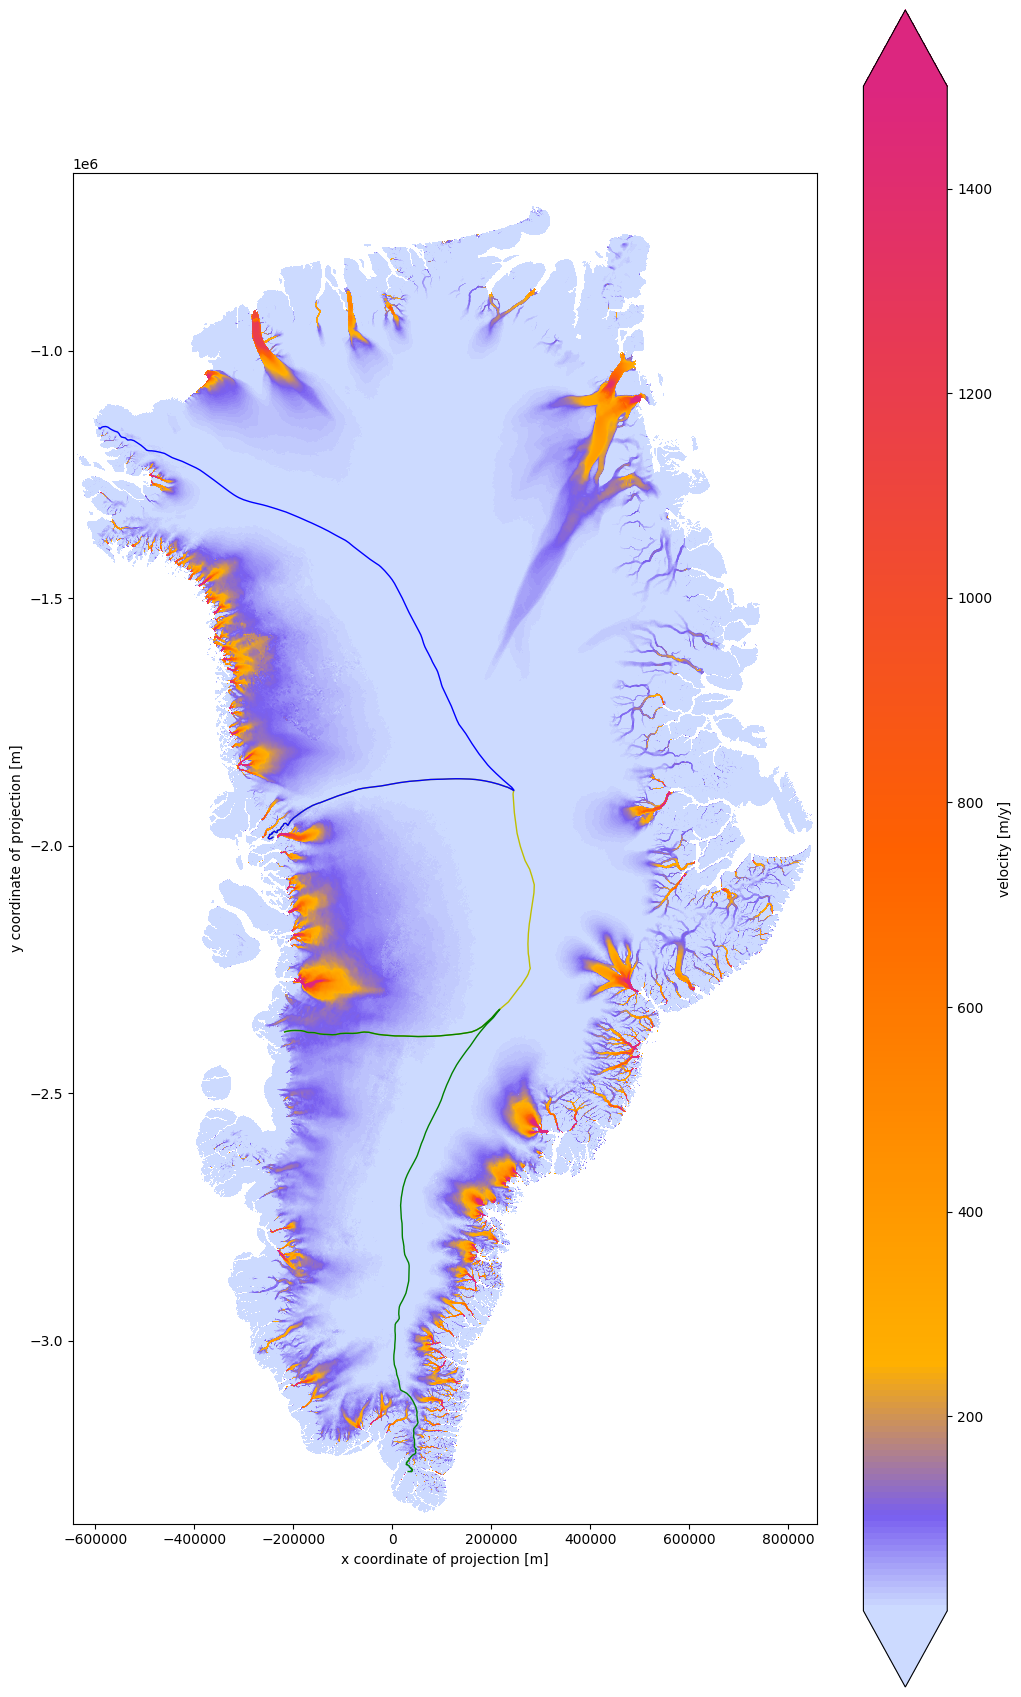

In [88]:
ratio = (y.max() - y.min()) / (x.max() - x.min())
fig, ax = plt.subplots(1, figsize=(12, 12 * ratio))
ds["v"].plot(ax=ax, cmap="speed_colorblind", vmin=10, vmax=1500)
CW.plot(markersize=25,
            color="y",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
SW.plot(markersize=25,
            color="g",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
NW.plot(markersize=25,
            color="b",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)

In [ ]:
import geopandas
from shapely import geometry
from shapely.ops import split, snap

gdf = gp.GeoDataFrame([
    {"Feature":'pathway',"ID":1,"geometry": geometry.result},
    {"Feature":'devide',"ID":2, "geometry": geometry.CW}
])

def split_line_by_point(line, point, tolerance: float=1.0e-12):
    return split(snap(line, point, tolerance), point)

result_line = (
    gdf
    .assign(geometry=gdf.apply(
        lambda x: split_line_by_point(
            x.geometry, 
            geometry.Point(x.geometry.coords[1])
        ), axis=1
    ))
    .explode()
    .reset_index(drop=True)
)

import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import mapping
import matplotlib.pyplot as plt

df = gp.read_file('PROMICE_GrIS_0_Stereo.shp')

#df = df.loc[df['Field']=='SomeValue']

inras = 'myraster.tif'

src  = rasterio.open(inras)
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
coords = getFeatures(df)
clipped_array, clipped_transform = mask(dataset=src, shapes=coords, crop=True)

df = df.to_crs(src.crs)
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": clipped_array.shape[1],
                 "width": clipped_array.shape[2],
                 "transform": clipped_transform})
out_tif= "clipped_example.tif"
with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(clipped_array)
    
clipped = rasterio.open(out_tif)
fig, ax = plt.subplots(figsize=(8, 6))
p1 = df.plot(color=None,facecolor='none',edgecolor='red',linewidth = 2,ax=ax)
show(clipped, ax=ax)
ax.axis('off');

In [ ]:
line1 = gp.read_file("data_stuff/Geometries/front.shp")
line2 = gp.read_file("data_stuff/Geometries/line_n.shp")
line3 = gp.read_file("data_stuff/Geometries/line_s.shp")
line4 = gp.read_file("data_stuff/Geometries/to_divide.shp")
s = gp.GeoSeries([line1.geometry[0], line2.geometry[0], line3.geometry[0], line4.geometry[0]])
poly = s.convex_hull
area = poly.area
area
poly.plot()

# 3. Compute Area

In [521]:
hmin = 0.05
hmax = 10.0
tol = 0.1
start_time = 0
end_time = 5_000
v_threshold = 10
starting_points = [ 
                    Point(-188_000, -2_255_000), Point(-182_000, -2_290_000)
]

ds = xr.open_dataset("data/its_live_jak.nc")
Vx = np.squeeze(ds["vx"].to_numpy())
Vy = np.squeeze(ds["vy"].to_numpy())

# Reverse for backward pathlines
Vx = -Vx
Vy = -Vy

x = ds["x"].to_numpy()
y = ds["y"].to_numpy()

geom = starting_points
starting_points_df = gp.GeoDataFrame(geometry=geom, crs="EPSG:3413")

pathlines = []
for _, df in starting_points_df.iterrows():
    pathline = compute_pathline(
        [*df.geometry.coords[0]],
        velocity,
        f_args=(Vx, Vy, x, y),
        hmin=hmin,
        hmax=hmax,
        tol=tol,
        start_time=start_time,
        end_time=end_time,
        notebook=True,
        progress=True,
        v_threshold = v_threshold
    )
    pathlines.append(pathline)


Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

In [522]:
# Combine the pathlines into a GeoPandas DataFrame

result = pd.concat(        [
    series_to_pathline_geopandas_dataframe(s.drop("geometry", errors="ignore"), pathlines[k])
    for k, s in starting_points_df.iterrows()
]
                  ).reset_index(drop=True)


In [523]:
# Combine the pathlines into a GeoPandas DataFrame

result = pd.concat(        [
    series_to_pathline_geopandas_dataframe(s.drop("geometry", errors="ignore"), pathlines[k])
    for k, s in starting_points_df.iterrows()
]
                  ).reset_index(drop=True)


In [524]:
# Now results are lines
result = pd.concat(
        [
            pathline_to_line_geopandas_dataframe(pathlines[k][0], attrs={"pathline_id": [k]})
            for k, _ in starting_points_df.iterrows()
        ]
    ).reset_index(drop=True)
result.to_file('2lines.shp', mode="w")

/var/folders/nd/kkcv2d591j11jk2h39wv8_zr0000gr/T/ipykernel_15135/827185828.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result.to_file('2lines.shp', mode="w")


<Axes: xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

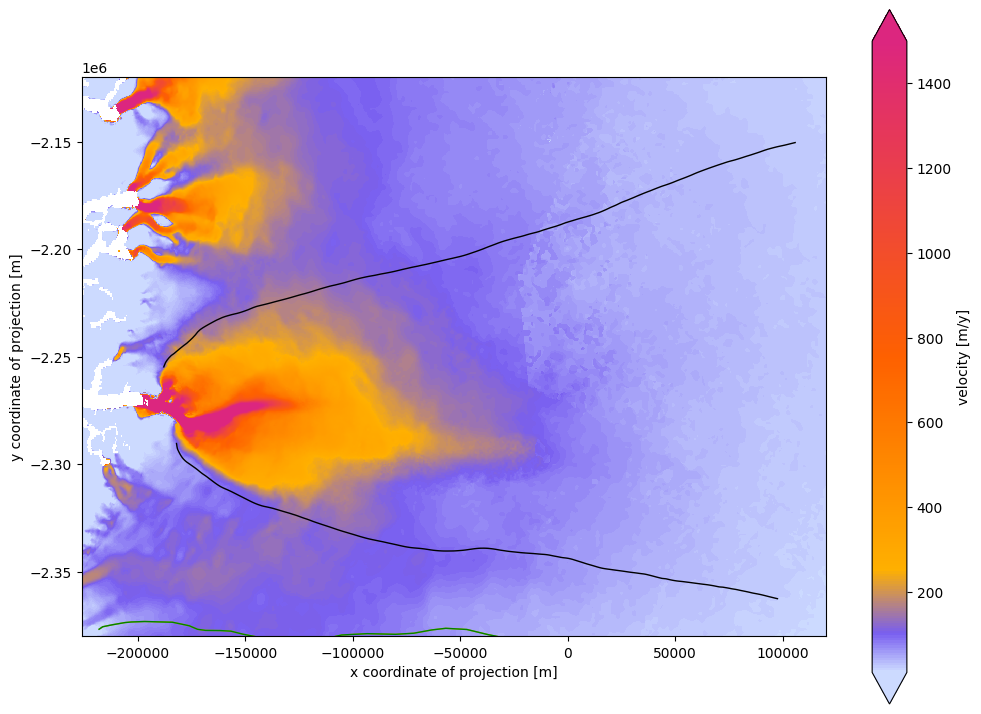

In [525]:
ratio = (y.max() - y.min()) / (x.max() - x.min())
fig, ax = plt.subplots(1, figsize=(12, 12 * ratio))
ax.set_xlim(-2_395_861, -1_846_930)
ax.set_ylim( -271_923, 308_375)
ds["v"].plot(ax=ax, cmap="speed_colorblind", vmin=10, vmax=1500)
result.plot(markersize=25,
            color="black",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
CW.plot(markersize=25,
            color="y",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
SW.plot(markersize=25,
            color="g",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
NW.plot(markersize=25,
            color="b",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)

In [527]:
# Connect the terminus dots with a straight line, for now, testing the area calculation. 
term_line = LineString(shapely.get_point(result.geometry,0))

In [528]:
# Connect the terminus dots with a straight line, for now, testing the area calculation. 
end_line = LineString(shapely.get_point(result.geometry,-1))

In [529]:
gp.GeoSeries(term_line, crs="EPSG:3413")
gp.GeoSeries(end_line, crs="EPSG:3413")

0    LINESTRING (106117.572 -2150278.476, 97895.983...
dtype: geometry

In [530]:
tl = gp.GeoDataFrame(geometry=[term_line], crs="EPSG:3413")
el = gp.GeoDataFrame(geometry=[end_line], crs="EPSG:3413")

In [531]:
merged = pd.concat([tl, el, result])

<Axes: >

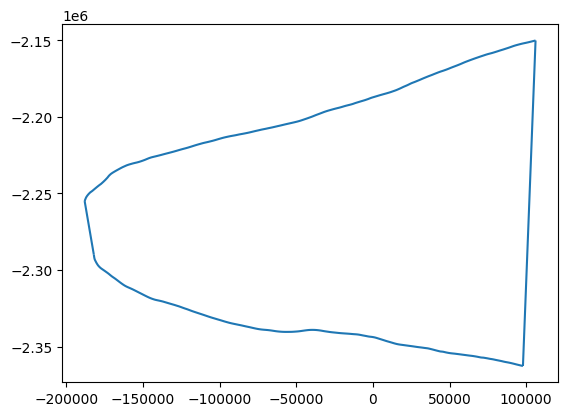

In [532]:
merged.plot()

In [533]:
poly = merged.convex_hull
area = poly.area
area

0    0.000000e+00
0    0.000000e+00
0    2.195265e+09
1    3.711219e+09
dtype: float64

In [305]:
poly = merged.convex_hull
area = poly.area
area

0    0.000000e+00
0    0.000000e+00
0    2.195265e+09
1    3.711219e+09
dtype: float64

<Axes: >

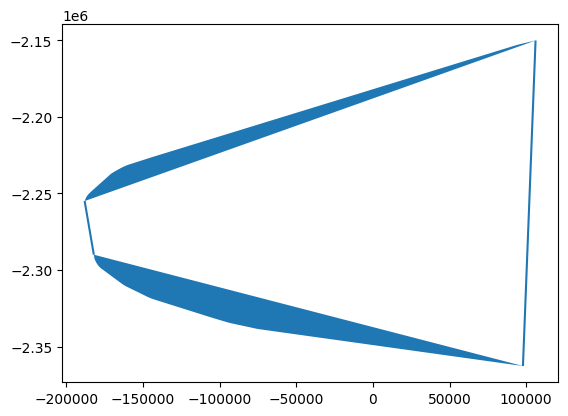

In [534]:
poly.plot()

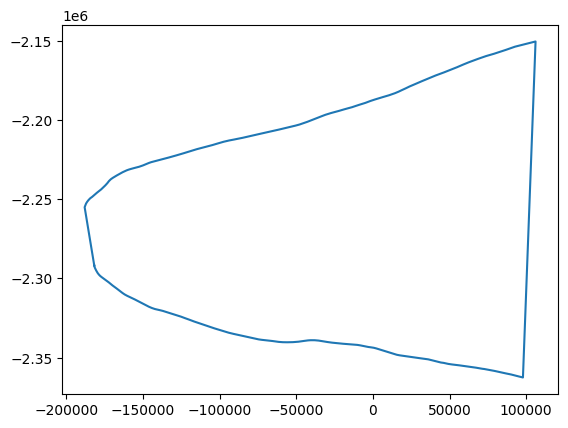

In [535]:
buffer_size = 0.5
buff_union = shapely.ops.unary_union([merged.buffer(buffer_size)])

# If the command above fails, try union first and then buffer:
# buff_union = shapely.ops.unary_union([b1,b2,t1,t2]).buffer(buffer_size)

# Extracting all the interior geometries
# Idea taken from here: https://stackoverflow.com/a/21922058/8667016
all_internal_geoms = [geom for geom in buff_union.interiors]

# Fishing out the interior geometry we really need
internal_geom = all_internal_geoms[0]

# Plotting results
# Code taken from here: https://stackoverflow.com/a/56140178/8667016
plt.plot(*internal_geom.xy)

In [421]:
# merged.to_file('merged.gpkg')

In [536]:
poly = internal_geom.convex_hull
area = poly.area
area

41375897288.04081

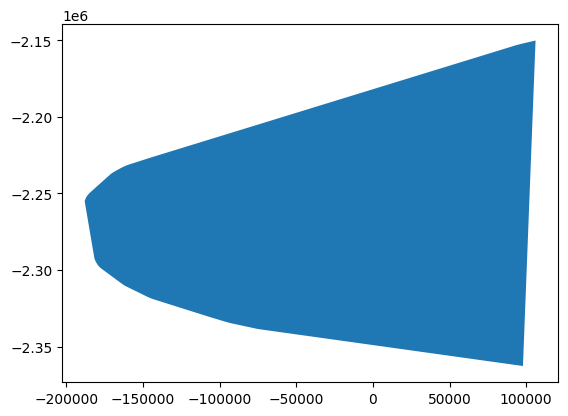

In [537]:
myPoly = gp.GeoSeries([poly])
myPoly.plot()
plt.show()

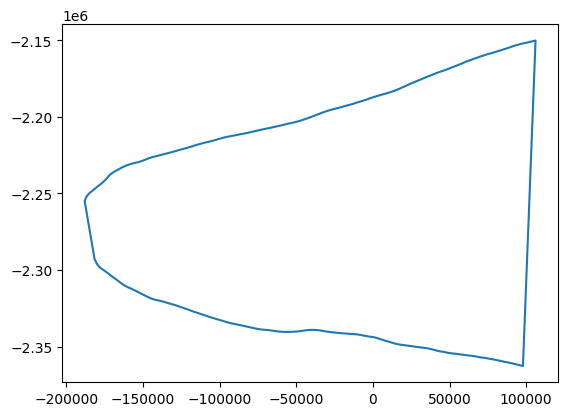

In [538]:
myRing = gp.GeoSeries([internal_geom], crs="EPSG:3413")
myRing.plot()
plt.show()

In [539]:
ratio = (y.max() - y.min()) / (x.max() - x.min())
fig, ax = plt.subplots(1, figsize=(12, 12 * ratio))
ax.set_xlim(-2_395_861, -1_846_930)
ax.set_ylim( -271_923, 308_375)
ds["v"].plot(ax=ax, cmap="speed_colorblind", vmin=10, vmax=1500)
myRing.plot(markersize=25,
            color="black",
            missing_kwds={}
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
CW.plot(markersize=25,
            color="y",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
SW.plot(markersize=25,
            color="g",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
NW.plot(markersize=25,
            color="b",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3259748560.py, line 8)

# 4. Area for many glaciers

In [575]:
x_coord = list(range(-180_000, -170_000, 1000))
y_coord_n = list(range(-2_290_000, -2_280_000, 5000))
y_coord_s = list(range(-2_260_000, -2_250_000, 5000))
box_points_n = []
for i in range(0,len(x_coord)):
    for j in range(0,len(y_coord_n)):
        box_points_n += [Point(x_coord[i],y_coord_n[j])]
box_points_s = []
for i in range(0,len(x_coord)):
    for j in range(0,len(y_coord_s)):
        box_points_s += [Point(x_coord[i],y_coord_s[j])]

In [576]:
hmin = 0.01
hmax = 25.0
tol = 1
start_time = 0
end_time = 10_000

ds = xr.open_dataset("data/its_live_jak.nc")
Vx = np.squeeze(ds["vx"].to_numpy())
Vy = np.squeeze(ds["vy"].to_numpy())

# Reverse for backward pathlines
Vx = -Vx
Vy = -Vy

x = ds["x"].to_numpy()
y = ds["y"].to_numpy()

geom = box_points_n
starting_points_df = gp.GeoDataFrame(geometry=geom, crs="EPSG:3413")

pathlines = []
for _, df in starting_points_df.iterrows():
    pathline = compute_pathline(
        [*df.geometry.coords[0]],
        velocity,
        f_args=(Vx, Vy, x, y),
        hmin=hmin,
        hmax=hmax,
        tol=tol,
        start_time=start_time,
        end_time=end_time,
        notebook=True,
        progress=True,
    )
    pathlines.append(pathline)

# Combine the pathlines into a GeoPandas DataFrame

result = pd.concat(        [
    series_to_pathline_geopandas_dataframe(s.drop("geometry", errors="ignore"), pathlines[k])
    for k, s in starting_points_df.iterrows()
]
                  ).reset_index(drop=True)

# Now results are lines
result_n = pd.concat(
        [
            pathline_to_line_geopandas_dataframe(pathlines[k][0], attrs={"pathline_id": [k]})
            for k, _ in starting_points_df.iterrows()
        ]
    ).reset_index(drop=True)

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/10000 [00:00<?, ?it/s]

In [577]:
hmin = 0.01
hmax = 25.0
tol = 1
start_time = 0
end_time = 5_000

ds = xr.open_dataset("data/its_live_jak.nc")
Vx = np.squeeze(ds["vx"].to_numpy())
Vy = np.squeeze(ds["vy"].to_numpy())

# Reverse for backward pathlines
Vx = -Vx
Vy = -Vy

x = ds["x"].to_numpy()
y = ds["y"].to_numpy()

geom = box_points_s
starting_points_df = gp.GeoDataFrame(geometry=geom, crs="EPSG:3413")

pathlines = []
for _, df in starting_points_df.iterrows():
    pathline = compute_pathline(
        [*df.geometry.coords[0]],
        velocity,
        f_args=(Vx, Vy, x, y),
        hmin=hmin,
        hmax=hmax,
        tol=tol,
        start_time=start_time,
        end_time=end_time,
        notebook=True,
        progress=True,
    )
    pathlines.append(pathline)

# Combine the pathlines into a GeoPandas DataFrame

result = pd.concat(        [
    series_to_pathline_geopandas_dataframe(s.drop("geometry", errors="ignore"), pathlines[k])
    for k, s in starting_points_df.iterrows()
]
                  ).reset_index(drop=True)

# Now results are lines
result_s = pd.concat(
        [
            pathline_to_line_geopandas_dataframe(pathlines[k][0], attrs={"pathline_id": [k]})
            for k, _ in starting_points_df.iterrows()
        ]
    ).reset_index(drop=True)

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

Integrating pathline:   0%|          | 0/5000 [00:00<?, ?it/s]

In [578]:
# Connect the terminus dots with a straight line, for now, testing the area calculation. 
n_starts = shapely.get_point(result_n.geometry,0)
s_starts = shapely.get_point(result_s.geometry,0)
term_line = []
for i in range(0,len(n_starts)):
    for j in range(0,len(s_starts)):
        term_line += [LineString([n_starts[i],s_starts[j]])]

# Connect the terminus dots with a straight line, for now, testing the area calculation. 
n_ends = shapely.get_point(result_n.geometry,-1)
s_ends = shapely.get_point(result_s.geometry,-1)
end_line = []
for i in range(0,len(n_ends)):
    for j in range(0,len(s_ends)):
        end_line += [LineString([n_ends[i],s_ends[j]])]

myRing = []
area = []

for i in range(0,len(result_n)):
    for j in range(0,len(result_s)):
        rn = result_n.geometry[i]
        rs = result_s.geometry[j]
        gp.GeoSeries(term_line[j], crs="EPSG:3413")
        gp.GeoSeries(end_line[j], crs="EPSG:3413")
        gp.GeoSeries(rn, crs="EPSG:3413")
        gp.GeoSeries(rs, crs="EPSG:3413")

        tl = gp.GeoDataFrame(geometry=[term_line[j]], crs="EPSG:3413")
        el = gp.GeoDataFrame(geometry=[end_line[j]], crs="EPSG:3413")
        rn = gp.GeoDataFrame(geometry=[rn], crs="EPSG:3413")
        rs = gp.GeoDataFrame(geometry=[rs], crs="EPSG:3413")
        merged = pd.concat([tl, el, rn, rs])

        buffer_size = 1
        buff_union = shapely.ops.unary_union(merged.buffer(buffer_size))
        # shapely.ops.unary_union(merged.buffer(1)
        # If the command above fails, try union first and then buffer:
        #buff_union = shapely.ops.unary_union([b1,b2,t1,t2]).buffer(buffer_size)

        # Extracting all the interior geometries
        # Idea taken from here: https://stackoverflow.com/a/21922058/8667016
        all_internal_geoms = [geom for geom in buff_union.interiors]

        # Fishing out the interior geometry we really need
        # internal_geom = all_internal_geoms[0]

        # poly = internal_geom.convex_hull
        area += [buff_union.area]
        print(buff_union.area / 1e6)

        myPoly = gp.GeoSeries([buff_union])

        myRing += [gp.GeoSeries([buff_union], crs="EPSG:3413")]

1.8894816051635743
1.9028680188751221
1.8878489439697266
1.9007048336105348
1.8859283367614745
1.8981713243255616
1.884035441871643
1.8968625603256226
1.8821352577285766
1.8946420630950929
1.8793715374679565
1.892198252670288
1.8778515357589722
1.8904302554092407
1.8775684891357423
1.8857506528015138
1.875837350227356
1.8837096614227296
1.8740540888290405
1.8820493602752686
1.8997409998626709
1.9131274074401856
1.8981655910339355
1.911021314933777
1.8962459856414795
1.908488700439453
1.8943539244003296
1.907180700942993
1.8924544410934447
1.904960858718872
1.889691314086914
1.9025176165924071
1.8881718270492553
1.900750118034363
1.887889229698181
1.8960709478378295
1.8861584769210815
1.8940303389205932
1.8843755543289185
1.8923703777542114
1.8893359533623997
1.9027223608216588
1.8877032942284886
1.900559177590305
1.8857826873902623
1.8980256690034214
1.883889794224674
1.8967169091729466
1.881989611107761
1.8944964142312353
1.8792258892678562
1.892052606862003
1.8777058922242467
1.89028

KeyboardInterrupt: 

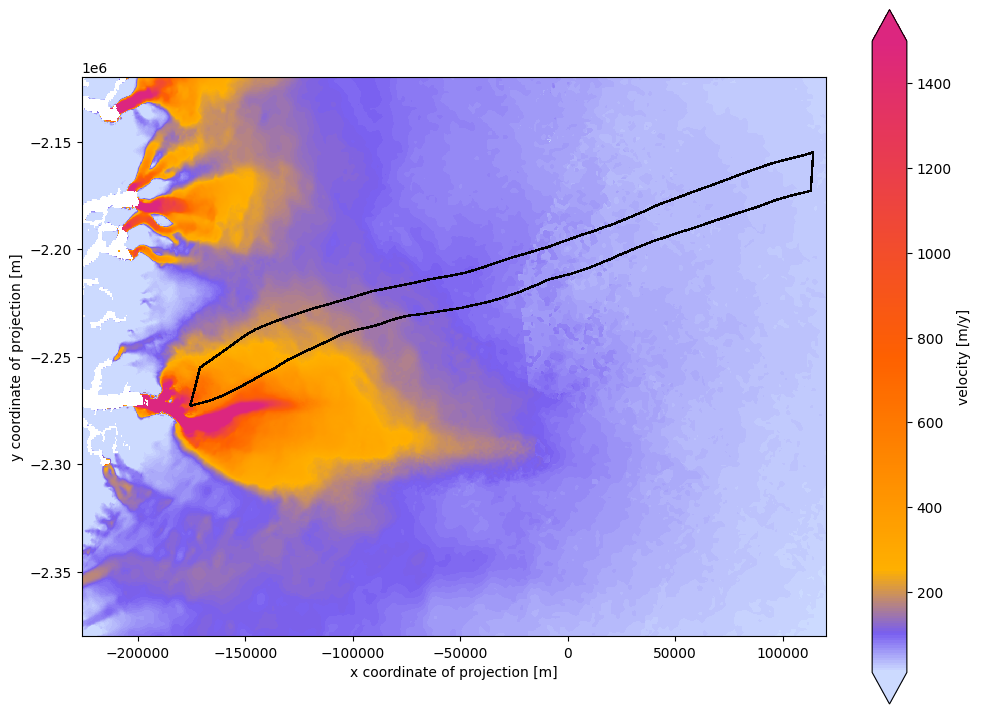

In [483]:
ratio = (y.max() - y.min()) / (x.max() - x.min())
fig, ax = plt.subplots(1, figsize=(12, 12 * ratio))
ax.set_xlim(-2_395_861, -1_846_930)
ax.set_ylim( -271_923, 308_375)
ds["v"].plot(ax=ax, cmap="speed_colorblind", vmin=10, vmax=1500)
for i in range(0,len(myRing)):    
    myRing[i].plot(markersize=25,
            color="black",
            ax=ax,
            edgecolors="k",
            linewidths=1,
    )
CW.plot(markersize=25,
            color="y",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
SW.plot(markersize=25,
            color="g",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)
NW.plot(markersize=25,
            color="b",
            legend=False,
            missing_kwds={},
            ax=ax,
            edgecolors="k",
            linewidths=1,
)

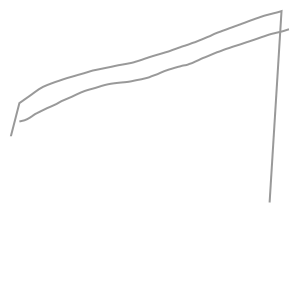

In [491]:
buff_union

(array([32., 41., 54., 61., 60., 53., 43., 27., 15., 14.]),
 array([1873908.45959943, 1879922.47276463, 1885936.48592983,
        1891950.49909504, 1897964.51226024, 1903978.52542544,
        1909992.53859064, 1916006.55175585, 1922020.56492105,
        1928034.57808625, 1934048.59125145]),
 <BarContainer object of 10 artists>)

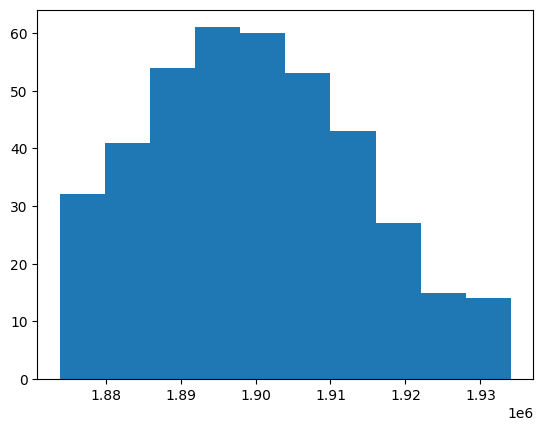

In [579]:
plt.hist(area)

<Axes: >

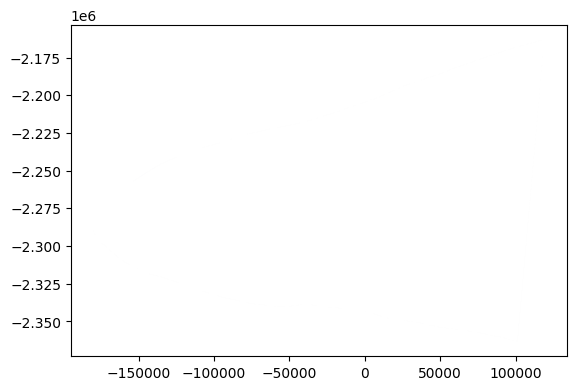

In [504]:
gp.GeoDataFrame(geometry = myRing[0],crs='EPSG:3413').plot()

<Axes: >

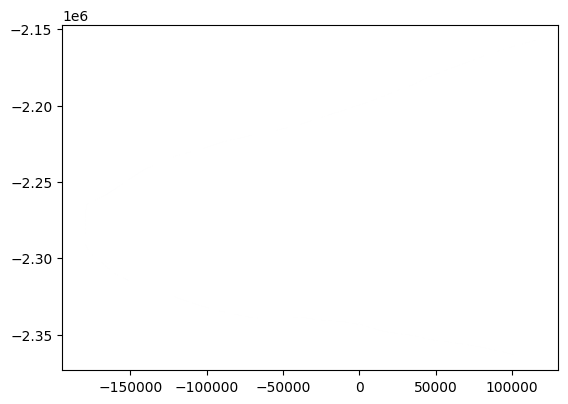

In [508]:
myRing[5].plot()

<Axes: >

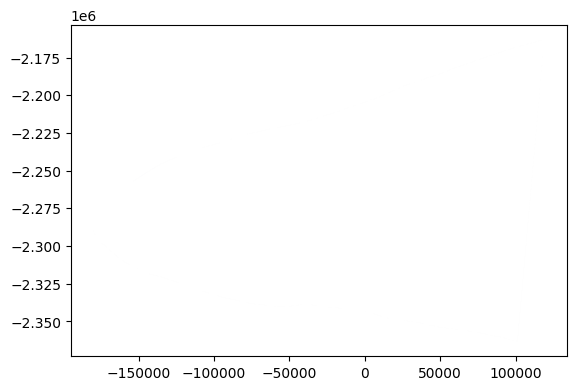

In [517]:
gp.GeoDataFrame(geometry=[myRing[0][0]], crs="EPSG:3413").plot(lw=3)

In [520]:
50e3 * 300e3

15000000000.0

In [545]:
all_internal_geoms

[]

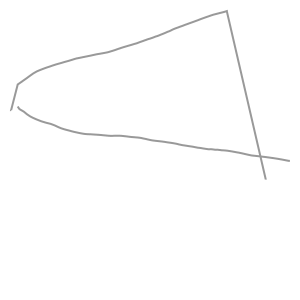

In [580]:
buff_union

In [573]:
shapely.ops.unary_union(merged.buffer(1)).area / 1e6

1.9957308687690465

<Axes: >

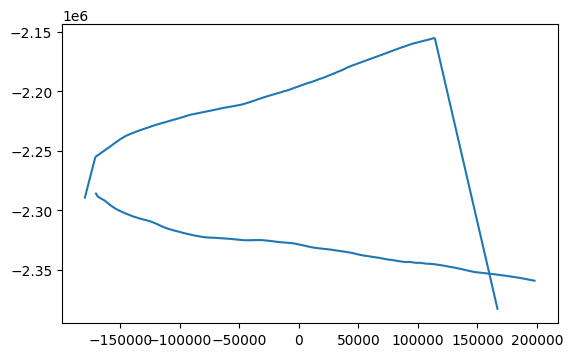

In [581]:
merged.plot()

In [607]:
myRing = []
area = []
for i in range(0,len(result_n.geometry)):
    for j in range(0,len(result_s.geometry)):
        rn = result_n.geometry[i]
        rs = result_s.geometry[j]
        n_starts = shapely.get_point(rn,0)
        s_starts = shapely.get_point(rs,0)
        term_line = LineString([n_starts,s_starts])

        # Connect the terminus dots with a straight line, for now, testing the area calculation. 
        n_ends = shapely.get_point(rn,-1)
        s_ends = shapely.get_point(rs,-1)
        end_line = LineString([n_ends,s_ends])

        gp.GeoSeries(term_line, crs="EPSG:3413")
        gp.GeoSeries(end_line, crs="EPSG:3413")
        gp.GeoSeries(rn, crs="EPSG:3413")
        gp.GeoSeries(rs, crs="EPSG:3413")

        tl = gp.GeoDataFrame(geometry=[term_line], crs="EPSG:3413")
        el = gp.GeoDataFrame(geometry=[end_line], crs="EPSG:3413")
        rn = gp.GeoDataFrame(geometry=[rn], crs="EPSG:3413")
        rs = gp.GeoDataFrame(geometry=[rs], crs="EPSG:3413")
        merged = pd.concat([tl, el, rn, rs])

        buffer_size = 0.5
        buff_union = shapely.ops.unary_union([merged.buffer(buffer_size)])

        # If the command above fails, try union first and then buffer:
        # buff_union = shapely.ops.unary_union([b1,b2,t1,t2]).buffer(buffer_size)

        # Extracting all the interior geometries
        # Idea taken from here: https://stackoverflow.com/a/21922058/8667016
        all_internal_geoms = [geom for geom in buff_union.interiors]

        # Fishing out the interior geometry we really need
        internal_geom = all_internal_geoms[0]

        # poly = internal_geom.convex_hull
        poly = internal_geom.convex_hull
        area += [poly.area]

        myPoly = gp.GeoSeries([poly])
        myRing += [gp.GeoSeries([internal_geom], crs="EPSG:3413")]

In [606]:
poly.area

44403607333.76435

(array([ 9., 32., 36., 36., 44., 47., 65., 69., 32., 30.]),
 array([4.36691748e+10, 4.41817340e+10, 4.46942932e+10, 4.52068524e+10,
        4.57194116e+10, 4.62319708e+10, 4.67445300e+10, 4.72570892e+10,
        4.77696484e+10, 4.82822076e+10, 4.87947668e+10]),
 <BarContainer object of 10 artists>)

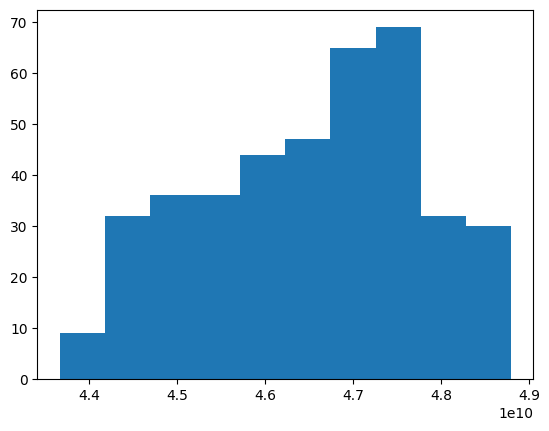

In [608]:
plt.hist(area)

In [614]:
a_mean = np.mean(area)

Text(0, 0.5, 'Count')

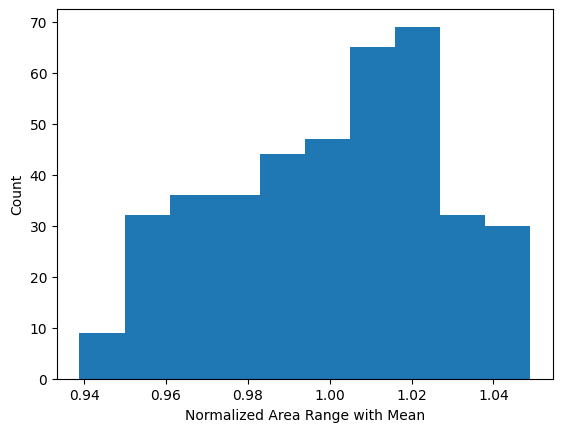

In [626]:
plt.hist(area/a_mean)
plt.xlabel('Normalized Area Range with Mean')
plt.ylabel('Count')

In [617]:
np.std(area)

1243056570.6616762

In [619]:
area_km = np.array(area)/1e6

In [620]:
np.std(area_km)

1243.0565706616762

In [622]:
mean_km = np.mean(area_km)

In [623]:
np.std(area_km/mean_km)

0.026724400652767162